## Before/after calibration NDVI time-series for some regions

In the areas with the worst correlation between MODIS and AVHRR, plot the timeseries before and after calibration to demonstrate the improvements

## Libraries

In [1]:
import sys
import xarray as xr
import numpy as np
import pandas as pd
import seaborn as sb
import matplotlib.pyplot as plt
from odc.geo.xr import assign_crs
import contextily as ctx
from statsmodels.tsa.seasonal import seasonal_decompose

sys.path.append('/g/data/os22/chad_tmp/AusEFlux/src/')
from _utils import round_coords

# Using ggplot styles in this notebook
plt.style.use('ggplot')

%matplotlib inline

/g/data/os22/chad_tmp/AusENDVI/env/py310/lib/python3.10/site-packages/dask/config.py:779: FutureWarning: Dask configuration key 'ucx' has been deprecated; please use 'distributed.comm.ucx' instead
  warnings.warn(
/g/data/os22/chad_tmp/AusENDVI/env/py310/lib/python3.10/site-packages/dask/config.py:779: FutureWarning: Dask configuration key 'distributed.scheduler.transition-log-length' has been deprecated; please use 'distributed.admin.low-level-log-length' instead
  warnings.warn(
/g/data/os22/chad_tmp/AusENDVI/env/py310/lib/python3.10/site-packages/dask/config.py:779: FutureWarning: Dask configuration key 'distributed.comm.recent-messages-log-length' has been deprecated; please use 'distributed.admin.low-level-log-length' instead
  warnings.warn(


## Analysis Parameters

In [2]:
model_var='NDVI'
crs='epsg:4326'
name='nontrees'

## Open data

In [7]:
base = '/g/data/os22/chad_tmp/AusENDVI/data/'

#open calibrated AVHRR
# merge = assign_crs(xr.open_dataset(base+'NDVI_harmonization/LGBM/NDVI_CLIM_LGBM_5km_monthly_1982_2022_wGaps.nc'),
#                    crs=crs)['NDVI']

trees = xr.open_dataset(base+'NDVI_harmonization/LGBM/NDVI_trees_CLIM_LGBM_harmonize_5km_monthly_1982_2013.nc')['NDVI']
nontrees = xr.open_dataset(base+'NDVI_harmonization/LGBM/NDVI_nontrees_CLIM_LGBM_harmonize_5km_monthly_1982_2013.nc')['NDVI']
desert = xr.open_dataset(base+'NDVI_harmonization/LGBM/NDVI_desert_CLIM_LGBM_harmonize_5km_monthly_1982_2013.nc')['NDVI']
merge = xr.where(np.isnan(trees), nontrees, trees)
merge = xr.where(np.isnan(desert), merge, desert)
merge = assign_crs(merge, crs=crs)
merge = merge.rename('NDVI')

#open original AVHRR
avhrr = xr.open_dataset(base+model_var+'_harmonization/AVHRR_NDVI_5km_monthly_1982_2013.nc')[model_var+'_avhrr']
avhrr = assign_crs(avhrr, crs=crs)

#Open MODIS
modis = xr.open_dataset(base+model_var+'_harmonization/MODIS_'+model_var+'_5km_monthly_200003_202212.nc')[model_var+'_median']
modis = assign_crs(modis, crs=crs)


## Mask areas

In [8]:
# #Tassie
# lat=slice(-39,-45) 
# lon=slice(144,149)
# plotname = 'tassie'

# #SW WA
# lat=slice(-31,-36) 
# lon=slice(114.5,119)
# plotname='WA'

# #queensland
# lat=slice(-10,-20) 
# lon=slice(140,150)
# plotname='QLD'

#WA cropping region
lat=slice(-31,-36) 
lon=slice(114.5,119)
plotname='crop'


In [9]:
# define no-data areas in calibrated
mask = ~np.isnan(merge)

#mask for the trees regions
trees = xr.open_dataset(base+'5km/WCF_5km_monthly_1982_2022.nc')['WCF']
trees = assign_crs(trees, crs ='epsg:4326')
trees = trees.sel(time=slice('2001', '2018'))
trees = trees.mean('time')

if name=='trees':
    mask1 = xr.where(trees>0.25, 1, 0)
if name=='nontrees':
    mask1 = xr.where(trees<=0.25, 1, 0)
    ag = assign_crs(xr.open_dataarray('/g/data/os22/chad_tmp/NEE_modelling/data/1km/Landcover_1km_monthly_2002_2021.nc').isel(time=0),
                crs='epsg:4326')
    ag = xr.where(ag==40,1,0)
    ag = ag.odc.reproject(merge.odc.geobox, resampling='mode')
    ag = round_coords(ag)

mask = round_coords(mask)
mask1 = round_coords(mask1)

# ds_ag = ds.where(ma).where(ag)

#do the masking
avhrr = avhrr.where(mask)
# merge = merge.where(mask1)
avhrr = avhrr.where(mask1)
modis = modis.where(mask1)

if plotname=='crop':
    avhrr = avhrr.where(ag)
    merge = merge.where(ag)


## Create a plot

In [13]:
roll=3

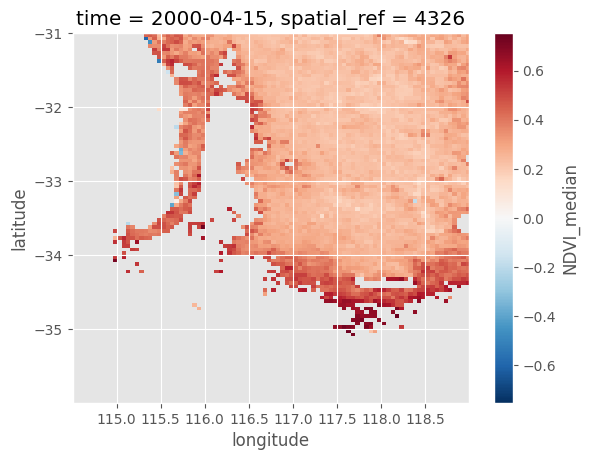

In [16]:
modis.sel(longitude=lon, latitude=lat).isel(time=1).plot.imshow()

/jobfs/110354600.gadi-pbs/ipykernel_2354038/3960357081.py:42: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax['C'].set_yticklabels(['{:3.2f}'.format(x) for x in ax['C'].get_yticks()])


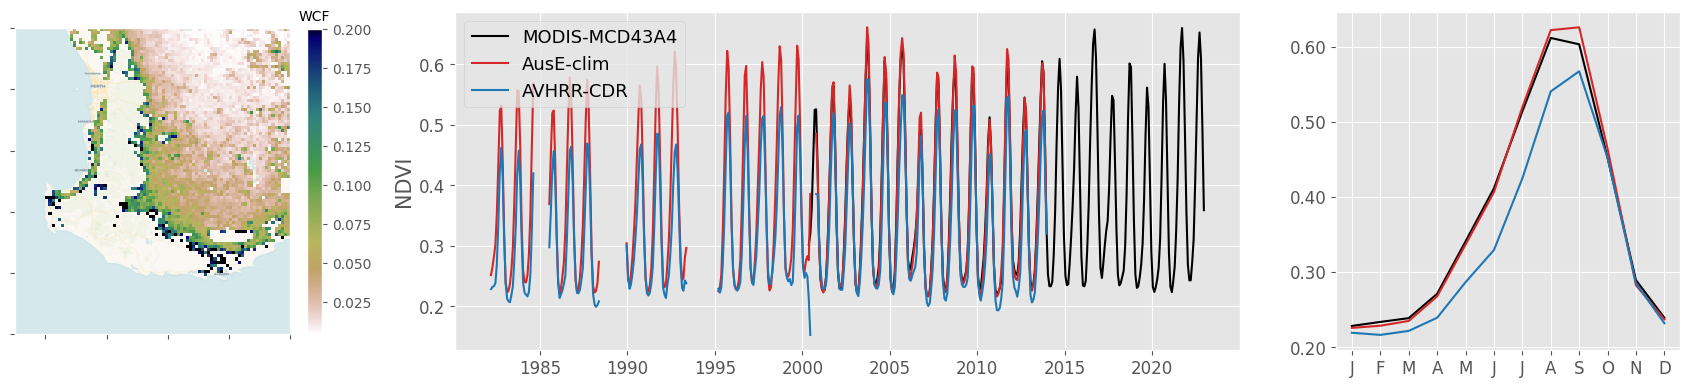

In [15]:
mosiac = [
    ["A", "B", "B", "C"],
]

fig, ax = plt.subplot_mosaic(mosiac, figsize=(17,4))

# im = trees.where(trees>0.25).sel(longitude=lon, latitude=lat).plot(robust=True, cmap='gist_earth_r',ax=ax['A'], add_colorbar=False, add_labels=False) 
im = trees.where(mask1).where(ag).sel(longitude=lon, latitude=lat).plot(robust=True, cmap='gist_earth_r',ax=ax['A'], add_colorbar=False, add_labels=False) 

cbar = plt.colorbar(im, ax=ax['A'], shrink=0.9)
cbar.ax.set_title('WCF', fontsize=10)
ax['A'].set_yticklabels([])
ax['A'].set_xticklabels([])
ax['A'].set_ylabel('')
ax['A'].set_xlabel('')
ctx.add_basemap(ax['A'], source=ctx.providers.CartoDB.Voyager, crs='EPSG:4326', attribution='', attribution_size=1)


modis.sel(longitude=lon, latitude=lat).mean(['latitude','longitude']).rolling(time=roll).mean().plot(ax=ax["B"], label='MODIS-MCD43A4', color='black')
merge.sel(longitude=lon, latitude=lat).mean(['latitude','longitude']).rolling(time=roll).mean().plot(ax=ax["B"], label='AusE-clim', color='tab:red')
avhrr.sel(longitude=lon, latitude=lat).mean(['latitude','longitude']).rolling(time=roll).mean().plot(ax=ax["B"], label='AVHRR-CDR', color='tab:blue')

ax["B"].grid(True)
ax["B"].legend(fontsize=13, loc='best')
ax["B"].set_title(None)
ax["B"].set_ylabel('NDVI', fontsize=15)
ax["B"].set_xlabel(None)
# ax["B"].set_ylim(0.425, 0.775)
ax['B'].tick_params(axis='y', labelsize=12)
ax['B'].tick_params(axis='x', labelsize=12)

modis.sel(longitude=lon, latitude=lat).sel(time=slice('2001','2013')).groupby('time.month').mean().mean(['latitude','longitude']).plot(ax=ax["C"], label='MODIS-MCD43A4', color='black')
merge.sel(longitude=lon, latitude=lat).sel(time=slice('2001','2013')).groupby('time.month').mean().mean(['latitude','longitude']).plot(ax=ax["C"], label='AusE-clim', color='tab:red')
avhrr.sel(longitude=lon, latitude=lat).sel(time=slice('2001','2013')).groupby('time.month').mean().mean(['latitude','longitude']).plot(ax=ax["C"], label='AVHRR-CDR', color='tab:blue')

# ax["C"].legend(fontsize=10)
ax["C"].set_title(None)
ax["C"].set_ylabel(None)
ax["C"].set_xlabel(None)
# ax["C"].set_ylim(0.425, 0.775)
ax['C'].tick_params(axis='y', labelsize=12)
ax['C'].set_yticklabels(['{:3.2f}'.format(x) for x in ax['C'].get_yticks()])
ax["C"].set_xticks(range(1,13))
ax["C"].set_xticklabels(["J","F","M","A","M","J","J","A","S","O","N","D"],fontsize=12)

plt.tight_layout();
# fig.savefig("/g/data/os22/chad_tmp/AusENDVI/results/figs/"+plotname+"_trees_timeseries.png",
#             bbox_inches='tight', dpi=300);

## Seasonal decomposition

In [17]:
def freq_to_scperiod(freq):
    freq = freq.rule_code.upper()

    if freq == 'A' or freq.startswith(('A-', 'AS-')):
        return 1
    elif freq == 'Q' or freq.startswith(('Q-', 'QS-')):
        return 4
    elif freq == 'M' or freq.startswith(('M-', 'MS')):
        return 12
    elif freq == 'W' or freq.startswith('W-'):
        return 52
    elif freq == 'D':
        return 365
    elif freq == 'H':
        return 365 * 24
    else:  # pragma : no cover
        raise ValueError("freq {} not understood. Please report if you "
                         "think this is in error.".format(freq))

def decompose_ts(da, freq='M'):
    # Construct a pandas time series with the xarray.DataArray :
    dt, c = '30 days', 1
    if freq == 'Y': dt, c = '365 day', 1
    if freq == 'D': dt, c = '1 day', 0
    index = pd.date_range(
        pd.to_datetime(str(da['time'].values[0])).strftime('%Y-%m-%d'),
        (pd.to_datetime(str(da['time'].values[-1])) + c * pd.Timedelta(dt)).strftime('%Y-%m-%d'), freq=freq)
    data = pd.Series(da.values, index=index)

    # Then decompose:
    result = seasonal_decompose(data, model='additive', extrapolate_trend='freq')

    # Create a new xarray.dataset with all signals:
    r = result.trend.to_xarray().rename('trend').to_dataset()
    r['seasonal'] = result.seasonal.to_xarray()
    r['resid'] = result.resid.to_xarray()
    r['observed'] = result.observed.to_xarray()
    r = r.rename({'index': 'time'})
    return r



In [18]:
avhrr_clim = avhrr.groupby("time.month").mean("time")
avhrr = avhrr.groupby("time.month").fillna(avhrr_clim)
modis = modis.sel(time=slice('2001','2013'))
avhrr = avhrr.sel(time=slice('2001','2013'))


In [19]:
modis_decomp = decompose_ts(modis.sel(longitude=lon, latitude=lat).mean(['latitude','longitude']))
avhrr_decomp = decompose_ts(avhrr.sel(longitude=lon, latitude=lat).mean(['latitude','longitude']))

/jobfs/110354600.gadi-pbs/ipykernel_2354038/2243269177.py:25: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  index = pd.date_range(
/jobfs/110354600.gadi-pbs/ipykernel_2354038/2243269177.py:25: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  index = pd.date_range(


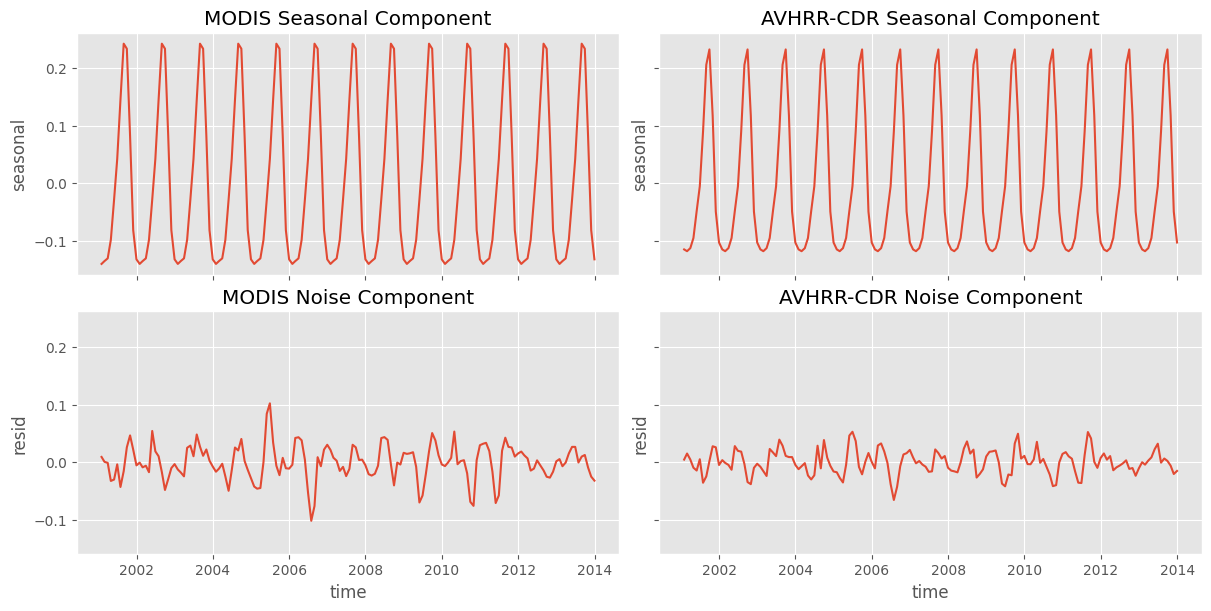

In [20]:
fig,ax = plt.subplots(2, 2, figsize=(12,6), sharex=True, sharey=True, layout='constrained')
modis_decomp.seasonal.plot(ax=ax[0,0])
modis_decomp.resid.plot(ax=ax[1,0])
avhrr_decomp.seasonal.plot(ax=ax[0,1])
avhrr_decomp.resid.plot(ax=ax[1,1]);
ax[0,0].set_xlabel(None)
ax[0,1].set_xlabel(None)
ax[0,0].set_title('MODIS Seasonal Component')
ax[0,1].set_title('AVHRR-CDR Seasonal Component')
ax[1,0].set_title('MODIS Noise Component')
ax[1,1].set_title('AVHRR-CDR Noise Component');

In [ ]:
fig,ax = plt.subplots(4, 1, figsize=(12,10))
avhrr_decomp.observed.plot(ax=ax[0])
avhrr_decomp.trend.plot(ax=ax[1])
avhrr_decomp.seasonal.plot(ax=ax[2])
avhrr_decomp.resid.plot(ax=ax[3])